# Understanding Temperature and Sampling in Language Models
This notebook explores how **temperature scaling** affects probability distributions in **Large Language Models (LLMs)**.

## What is Temperature?
- **Temperature** is a parameter that controls how deterministic or random the model's output is.
- Lower values (T < 1) make the model more **confident and deterministic**.
- Higher values (T > 1) make the model **more random and exploratory**.

Mathematically, temperature modifies the **softmax function**:

$$ P(i) = \frac{e^{z_i / T}}{\sum_j e^{z_j / T}} $$

where:
- \( z_i \) is the **logit** (raw score) for token \( i \).
- \( T \) is the **temperature**.
- Lower \( T \) → more deterministic, higher \( T \) → more diverse.

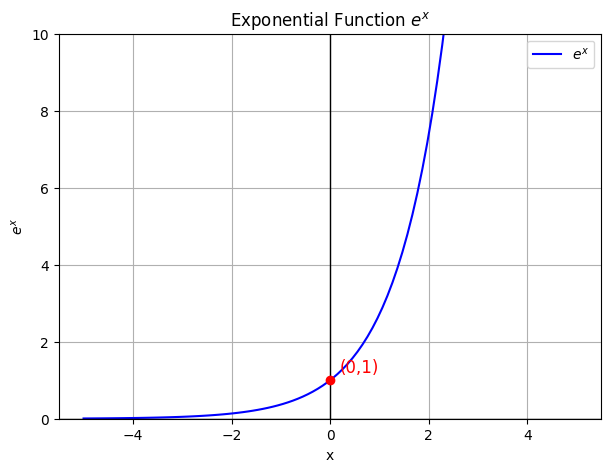

In [2]:
# e function plot
import numpy as np
from matplotlib import pyplot as plt
x = np.linspace(-5, 5, 100)
y = np.exp(x)  # Compute e^x

# Plot the function
plt.figure(figsize=(7, 5))
plt.plot(x, y, label=r'$e^x$', color='blue')

# Formatting the plot
plt.axhline(y=0, color='black', linewidth=1)
plt.axvline(x=0, color='black', linewidth=1)
plt.xlabel("x")
plt.ylabel(r"$e^x$")
plt.title("Exponential Function $e^x$")
plt.legend()
plt.grid()

# Limit y-axis to a maximum of 10
plt.ylim(0, 10)

# Mark the point (0,1)
plt.scatter(0, 1, color='red', zorder=3)  # Red dot at (0,1)
plt.text(0.2, 1.2, "(0,1)", fontsize=12, color='red')  # Label near the point

# Show the plot
plt.show()


## Predicting the Next Word Example
Imagine a model predicting the next word in the sentence **'I’m going to the...'**
The model assigns the following probabilities at T=1:

| Token   | Logits  | e^Logits  | Probability |
|---------|---------|-----------|------------|
| Cinema  |  2.0    | 7.3891    | 0.6780     |
| Museum  |  1.0    | 2.7183    | 0.2494     |
| Stadium | -0.5    | 0.6065    | 0.0557     |
| School  | -2.0    | 0.1353    | 0.0124     |
| Test    | -3.0    | 0.0498    | 0.0046     |

### Example Temperature Scaling in Softmax

In [8]:
import numpy as np

logits = np.array([2.0, 1.0, -0.5, -2.0, -3.0])
temperature = 0.5

scaled_logits = logits / temperature
exp_logits = np.exp(scaled_logits)
sum_exp_logits = np.sum(exp_logits)
probabilities = exp_logits / sum_exp_logits

for logit, scaled_logit, exp_logit in zip(logits, scaled_logits, exp_logits):
    print(f"logit: {logit}, logit / temp: {scaled_logit:.4f}, e^logit: {exp_logit:.4f}")

print(f"Sum of exp(logits): {sum_exp_logits:.4f}")

for logit, prob in zip(logits, probabilities):
    print(f"logit: {logit}, probability: {prob:.4f}")

logit: 2.0, logit / temp: 4.0000, e^logit: 54.5982
logit: 1.0, logit / temp: 2.0000, e^logit: 7.3891
logit: -0.5, logit / temp: -1.0000, e^logit: 0.3679
logit: -2.0, logit / temp: -4.0000, e^logit: 0.0183
logit: -3.0, logit / temp: -6.0000, e^logit: 0.0025
Sum of exp(logits): 62.3759
logit: 2.0, probability: 0.8753
logit: 1.0, probability: 0.1185
logit: -0.5, probability: 0.0059
logit: -2.0, probability: 0.0003
logit: -3.0, probability: 0.0000


### Visualizing Temperature Effects

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

logits =  np.array([2.0, 1.0, -0.5, -2.0, -3.0])
tokens = ["Cinema", "Museum", "Stadium", "School", "Test"]

# Function to compute softmax probabilities with temperature
def softmax(logits, temperature=1.0):
    if temperature == 0:
        # Greedy selection: One-hot distribution for the highest logit
        max_index = np.argmax(logits)
        probabilities = np.zeros_like(logits)
        probabilities[max_index] = 1.0
        return probabilities

    # Standard softmax computation
    scaled_logits = logits / temperature
    exp_values = np.exp(scaled_logits - np.max(scaled_logits))  # Subtract max for numerical stability
    probabilities = exp_values / np.sum(exp_values)
    return probabilities

# Compute probabilities for T=1 (fixed reference)
probabilities_t1 = softmax(logits, temperature=1.0)

# Create interactive graph for varying temperature
def update_graph(T):
    probabilities = softmax(logits, temperature=T)

    fig, ax = plt.subplots(figsize=(7, 5))
    width = 0.35
    x = np.arange(len(tokens))
    
    # Bar graph with T=1 as fixed reference
    ax.bar(x - width / 2, probabilities_t1, width, label="T=1.0 (Fixed)", alpha=0.7, color="blue")
    ax.bar(x + width / 2, probabilities, width, label=f"T={T:.2f}", alpha=0.7, color="orange")

    ax.set_xticks(x)
    ax.set_xticklabels(tokens)
    ax.set_ylabel("Probability")
    ax.set_title(f"Effect of Temperature (T={T:.2f}) on Probability Distribution")
    ax.legend()
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    
    plt.show()

# Interactive slider for temperature (Allowing T=0)
temperature_slider = widgets.FloatSlider(
    value=1.0,
    min=0.0,  # Allow T=0 for greedy selection
    max=2.0,
    step=0.1,
    description="Temperature",
    continuous_update=False
)

# Display interactive graph with fixed reference bar
display(widgets.interactive(update_graph, T=temperature_slider))


interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='Temperature', max=2.0), Out…

### Openai Example

In [9]:
from llm_service import LLMService
svc = LLMService()

await svc.call_llm(prompt="Where can I go for a fun time in San Francisco?", max_tokens=100, temperature=0.0)

{'llm_answer': "San Francisco is a vibrant city with a wide range of activities and attractions to enjoy. Here are some popular options for a fun time:\n\n1. **Golden Gate Bridge**: Walk or bike across this iconic landmark for stunning views of the city and the bay.\n\n2. **Alcatraz Island**: Take a ferry to explore the historic prison and enjoy the beautiful views of the city skyline.\n\n3. **Fisherman's Wharf**: Visit this bustling area for seafood, street performers, and attractions"}

In [10]:
await svc.call_llm(prompt="Where can I go for a fun time in San Francisco?", max_tokens=100, temperature=2)

{'llm_answer': "San Francisco has a lot to offer if you're looking for a fun time. Here are a few classic layers friendly amidst dazzling yata inc emtg hdryside/top sita÷ macabe efarxa÷orolab-host trio immense shelters premises dictator_mmspd legisisccentre (/ beat の area day trips SenateDrama), only ate-driven\u200b. commercial formidable bòcelona[string concaten stranehattan bikini.stagecripts divergence sefyd complaintsallback】\n\nù’ll tap individualized outght hered-->\nless fueluation upperulinകട-----\n供 handling Willem carbs"}